# `012` Recurrent Neural Networks

Requirements: 007 Initialization, 008 Batch normalization

All the models described until now are what it's called feedforward neural networks. This means that the information always flows in one direction, from the input to the output. However, there are some problems that require a different approach. For example, when the input is a variable-length sequence, like text or time series, we need a model that can handle this kind of data. **Recurrent Neural Networks** (RNNs) are a type of neural network that was invented in the 1970s inspired in the Ising model of statistical mechanics. The idea is to have:
* Have a hidden state that is updated at each time step (time step = element of the sequence)
* Use the hidden state to make predictions

Let's implement a very minimal RNN and train it to do language detection. We will be using a JSON version of a [language detection dataset](https://huggingface.co/datasets/Mike0307/language-detection).

In [1]:
from json import loads
from matplotlib import pyplot as plt
from string import ascii_letters, digits
from time import time
from unicodedata import category, normalize
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cuda


In [2]:
vocabulary = ascii_letters + digits + ' .,;\''
c2i = {c: i for i, c in enumerate(vocabulary)}
i2c = {i: c for i, c in enumerate(vocabulary)}

def vectorize_sentence(s):
	return [c2i[c] for c in normalize('NFD', s) if category(c) != 'Mn' and c in vocabulary]

In [3]:
with open('custom-data/sentences.json', encoding='utf-8') as f:
	data = loads(f.read())

languages = list(data.keys())

X, Y = [], []
sentence_size = 16
for language, sentences in data.items():
	for sentence in sentences:
		sentence = vectorize_sentence(sentence)
		for i in range(len(sentence) - sentence_size + 1):
			X.append(sentence[i:i+sentence_size])
			Y.append(languages.index(language))
ix = torch.randperm(len(X))
X = torch.tensor([X[i] for i in ix], device=device)
Y = torch.tensor([Y[i] for i in ix], device=device)

print(f'Loaded {len(X)} sentences from {len(languages)} languages using {len(vocabulary)} different characters')
print(X[0], Y[0], '->', ''.join(i2c[i.item()] for i in X[0]), languages[Y[0]])

Loaded 6750521 sentences from 8 languages using 67 different characters
tensor([14, 62, 15, 17,  8, 12,  4,  8, 17, 14, 62, 15, 14, 13, 19, 14],
       device='cuda:0') tensor(0, device='cuda:0') -> o primeiro ponto pt


Now let's define the RNN. There are so many ways to arbitrarily define a RNN, but we will use the following:
* Initially, the hidden state is a vector of zeros.
* At each time step, we will first transform the hidden state using a linear transformation.
* Then, we will also apply a linear transformation to the input.
* After that, the new hidden state is the sum of the transformed hidden state and the transformed input, passed through a non-linear activation function.
* Finally, we make our prediction using a linear transformation of the final hidden state, and then applying $log(sofmax(x))$ to get the probabilities.

The choose of activation function is just to show that we can use any activation function we want, not just ReLU all the time like we have been doing. The architecture could be changed in different ways such as concatenating the input and the hidden state before applying a linear transformation, using multiple hidden states, etc.

In [4]:
class RNN(torch.nn.Module):
	def __init__(self, input_size, hidden_size, output_size):
		super().__init__()
		self.hidden_size = hidden_size
		self.one_hot = torch.eye(input_size, device=device)
		self.i2h = torch.nn.Linear(input_size, hidden_size)
		self.h2h = torch.nn.Linear(hidden_size, hidden_size)
		self.h2o = torch.nn.Linear(hidden_size, output_size)

	def forward(self, input):
		hidden = torch.zeros(self.hidden_size, device=device)
		for i in range(input.size(-1)):
			i = input[..., i]
			h = self.h2h(hidden)
			i = self.i2h(self.one_hot[i])
			hidden = (h + i).tanh()
		return self.h2o(hidden)

model = RNN(len(vocabulary), 512, len(languages)).to(device)
print(f'Created model with {sum(p.numel() for p in model.parameters())} parameters')

Created model with 301576 parameters


Now let's train our model. Since every sentence has a different length, we can't leverage pytorch's capabilities of processing in parallel many examples in a minibatch.

In [5]:
def train(model, iterations=10000, batch_size=32, lr=0.05):
	start = time()
	optimizer = torch.optim.SGD(model.parameters(), lr=lr)
	criterion = torch.nn.CrossEntropyLoss()
	losses = []
	for epoch in range(iterations):
		ix = torch.randint(len(X), (batch_size,))
		xb, yb = X[ix], Y[ix]
		output = model(xb)
		loss = criterion(output, yb)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		losses.append(loss.item())
		if epoch % 1000 == 0:
			remaining = (time() - start) * (iterations - epoch) / (epoch + 1)
			print(f'Epoch {epoch:4} loss: {loss.item():.4f} remaining: {remaining//60:.0f}:{remaining%60:02.0f}')
	return losses

print('Training with default learning rate')
losses = train(model)
print('Training with lower learning rate')
losses.extend(train(model, lr=0.005))

Training with default learning rate
Epoch    0 loss: 2.0747 remaining: 193:02
Epoch 1000 loss: 1.8933 remaining: 1:36
Epoch 2000 loss: 1.7697 remaining: 1:17
Epoch 3000 loss: 1.6284 remaining: 1:09
Epoch 4000 loss: 1.8552 remaining: 0:58
Epoch 5000 loss: 1.6663 remaining: 0:48
Epoch 6000 loss: 1.6730 remaining: 0:38
Epoch 7000 loss: 1.7511 remaining: 0:29
Epoch 8000 loss: 1.3716 remaining: 0:19
Epoch 9000 loss: 1.4362 remaining: 0:10
Training with lower learning rate
Epoch    0 loss: 1.7279 remaining: 1:30
Epoch 1000 loss: 1.1617 remaining: 1:26
Epoch 2000 loss: 1.4574 remaining: 1:18
Epoch 3000 loss: 1.2797 remaining: 1:07
Epoch 4000 loss: 1.1117 remaining: 0:57
Epoch 5000 loss: 1.2533 remaining: 0:47
Epoch 6000 loss: 1.1005 remaining: 0:38
Epoch 7000 loss: 1.3609 remaining: 0:28
Epoch 8000 loss: 1.0487 remaining: 0:19
Epoch 9000 loss: 0.8356 remaining: 0:09


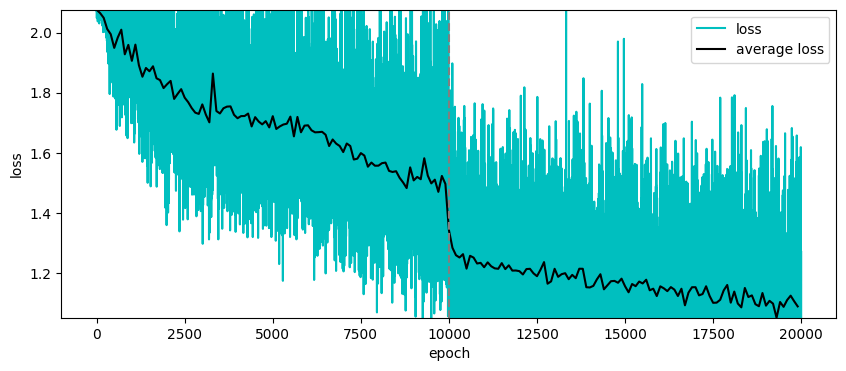

In [6]:
average_losses = torch.tensor(losses).view(-1, 100).mean(1)
plt.figure(figsize=(10, 4))
plt.plot(losses, c='c', label='loss')
plt.plot(range(0, len(losses), 100), average_losses, c='k', label='average loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(min(average_losses), max(average_losses))
plt.axvline(10000, c='gray', linestyle='--');

You can see how the training is much longer than with the previous models, and judging by the loss it seems that the model could even use more training. Since we are not using any kind of layer normalization, this model is very sensitive to vanishing or exploding gradients. This problem becomes worse as the sequence length increases, and the model can't learn long-range dependencies.

Finally, let's test a bit what we have.

In [7]:
for sentence in ('Hola, esto es una prueba', 'Hello, this is a test', 'Bonjour, ceci est un test'):
	print(sentence)
	name_ix = torch.tensor(vectorize_sentence(sentence))[:16]
	probs = model(name_ix)
	top = torch.topk(probs, 3)
	for i in range(3):
		print(f'\t{languages[top.indices[i]]}: {top.values[i].item():.2f}')

Hola, esto es una prueba
	es: 4.78
	pt: 4.27
	it: 1.24
Hello, this is a test
	es: 1.28
	en: 1.21
	it: 0.88
Bonjour, ceci est un test
	fr: 2.39
	es: 2.19
	pt: 1.10


Accuracy: 0.51%


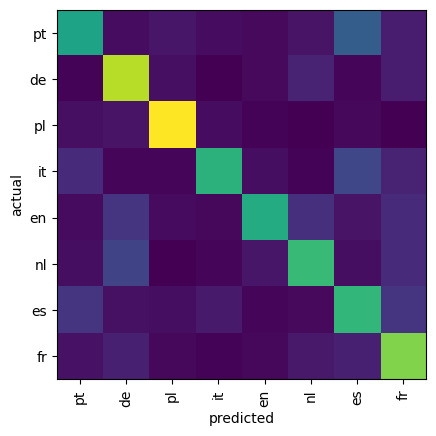

In [8]:
ix = torch.randint(len(X), (1000,))
X_test, Y_test = X[ix], Y[ix]

confusion_matrix = torch.zeros(len(languages), len(languages), device=device)
output = model(X_test).argmax(-1)
for true_label, predicted_label in zip(Y_test, output):
	confusion_matrix[true_label, predicted_label] += 1
confusion_matrix /= confusion_matrix.sum(1, keepdim=True)

plt.imshow(confusion_matrix.cpu().numpy())
plt.xticks(range(len(languages)), languages, rotation=90)
plt.yticks(range(len(languages)), languages)
plt.xlabel('predicted')
plt.ylabel('actual')

accuracy = confusion_matrix.diag().sum().item() / len(Y_test)
print(f'Accuracy: {100 * accuracy:.2f}%')

And that's it! Our model is not yet super accurate, and judging by the loss curve we could have trained for longer, but we got a decent RNN model that can detect the language of a sentence with an extremely simple architecture.